**Enable autoreload extension**

In [1]:
%load_ext autoreload
%autoreload 3

**Setup dependencies**

In [2]:
!apt-get update --fix-missing
!apt-get install -y libspatialindex-dev
%pip install --upgrade pip wheel
%pip install eclipse-sumo==1.10.0
%env SUMO_HOME=/usr/local/lib/python3.7/dist-packages/sumo
%pip install git+https://github.com/huawei-noah/SMARTS.git@0afcc1a85e10669aeca438e468d37fd5c1fbefd4#egg=smarts[camera-obs]
!rm -rf /content/SMARTS
!git clone https://github.com/huawei-noah/SMARTS /content/SMARTS

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://ppa

**Import Base Modules**

In [3]:
import gym
import numpy as np

import smarts
import smarts.core
import smarts.env

**Setup Visualization**

In [19]:
import glob
import cv2
from pathlib import Path

from collections import defaultdict
from PIL import Image, ImageDraw



def flatten_obs(sim_obs):
    obs = []
    for agent_id, agent_obs in sim_obs.items():
        if agent_obs is None:
            continue
        elif isinstance(agent_obs, dict):  # is_boid_agent
            for vehicle_id, vehicle_obs in agent_obs.items():
                obs.append((vehicle_id, vehicle_obs))
        else:
            obs.append((agent_id, agent_obs))
    return obs

def vis_sim_obs(sim_obs):
    vis_images = defaultdict(list)

    for agent_id, agent_obs in flatten_obs(sim_obs):
        # Visdom image format: Channel x Height x Width
        drivable_area = getattr(agent_obs, "drivable_area_grid_map", None)
        if drivable_area is not None:
            image = drivable_area.data
            # image = image.transpose(2, 0, 1)
            image = image.astype(np.float32)
            vis_images[f"{agent_id}-DrivableAreaGridMap"].append(image)

        ogm = getattr(agent_obs, "occupancy_grid_map", None)
        if ogm is not None:
            image = ogm.data
            image = image.reshape(image.shape[0], image.shape[1])
            image = np.expand_dims(image, axis=0)
            image = (image.astype(np.float32) / 100) * 255
            vis_images[f"{agent_id}-OGM"].append(image)

        rgb = getattr(agent_obs, "top_down_rgb", None)
        if rgb is not None:
            image = rgb.data
            # image = image.transpose(2, 0, 1)
            image = image.astype(np.float32)
            vis_images[f"{agent_id}-Top-Down-RGB"].append(image)

    return vis_images

_image_num = 0
def write_image(sim_obs, frame_folder):
    global _image_num
    _image_num += 1

    im_obs = vis_sim_obs(sim_obs)
    for im_id, im in im_obs.items():
      out = np.array(im)
      # print(out.shape)
      # print(im_id)
      cv2.imwrite(f"{frame_folder}/{im_id}_{_image_num}.JPG", out[0])


def make_gif(frame_folder):
    frames = []
    for image in sorted(glob.glob(f"{frame_folder}/*.JPG"), key=lambda im: int(Path(im).name.split("_")[-1].split(".")[0])):
        frames.append(Image.open(image))
    frame_one = frames[0]
    print(frame_one.info)
    frame_one.save(f"{frame_folder}/a_gif.gif", format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)

**Setup Debug Logging Temporarily**

In [ ]:
import logging
import sys

root = logging.getLogger()
root.setLevel(logging.DEBUG)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

**Define a new agent for this example**

In [5]:
from smarts.core.agent import Agent
from smarts.core.sensors import Observation

class ChaseViaPointsAgent(Agent):
    def act(self, obs: Observation):
        if (
            len(obs.via_data.near_via_points) < 1
            or obs.ego_vehicle_state.road_id != obs.via_data.near_via_points[0].road_id
        ):
            return (obs.waypoint_paths[0][0].speed_limit, 0)

        nearest = obs.via_data.near_via_points[0]
        if nearest.lane_index == obs.ego_vehicle_state.lane_index:
            return (nearest.required_speed, 0)

        return (
            nearest.required_speed,
            1 if nearest.lane_index > obs.ego_vehicle_state.lane_index else -1,
        )

**Create an Environment (likely elsewhere)**

In [28]:
from smarts.core.agent import AgentSpec
from smarts.core.agent_interface import AgentInterface, AgentType
from smarts.env.wrappers.single_agent import SingleAgent


agent_spec = AgentSpec(
    interface=AgentInterface.from_type(
        AgentType.LanerWithSpeed,
        max_episode_steps=150,
        rgb=True
    ),
    agent_builder=ChaseViaPointsAgent
)

def entry_point(*args, **kwargs):
  from smarts.env.hiway_env import HiWayEnv
  scenario = "/content/SMARTS/scenarios/figure_eight"
  ## Note: can build the scenario here
  from cli.studio import _build_single_scenario
  _build_single_scenario(clean=True, allow_offset_map=True, scenario=scenario)
  return SingleAgent(
    HiWayEnv(
      agent_specs={"agent-007": agent_spec},
      scenarios=[scenario],
      headless=True,
      sumo_headless=True
  ))

gym.register(
    "figure_eight-v1",
    entry_point=entry_point
)

**Run an episode**

In [29]:
import os
import shutil
frame_folder = f"{os.path.expanduser('~')}/videos"
try:
  shutil.rmtree(frame_folder)
except: pass
os.mkdir(frame_folder)
env = gym.make("figure_eight-v1")

build-scenario /content/SMARTS/scenarios/figure_eight


In [30]:
from smarts.core.utils.episodes import episodes


for episode in episodes(n=1):
    agent = agent_spec.build_agent()
    observation = env.reset()
    episode.record_scenario(env.scenario_log)

    done = False
    while not done:
        agent_action = agent.act(observation)
        observation, reward, done, info = env.step(agent_action)
        write_image({"agent": observation}, frame_folder)
        episode.record_step(observation, reward, done, info)

env.close()
print ('Success')

╭────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────╮
│            Episode │     Sim T / Wall T │        Total Steps │        Steps / Sec │       Scenario Map │    Scenario Routes │     Mission (Hash) │             Scores │
├────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

│                0/1 │               3.33 │                149 │              33.30 │       figure_eight │                    │ 791134346791398780 │ 203.13 - SingleAgent │
╰────────────────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────╯
Success


In [31]:
make_gif(frame_folder)

{'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}


/root/videos/a_gif.gif


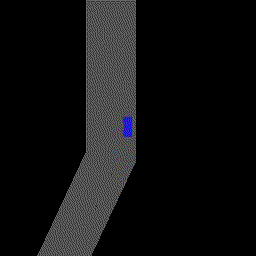

In [32]:
from IPython import display as ipythondisplay
from pathlib import Path


def show_videos(path="videos"):
  for gif in Path(path).glob("*.gif"):
    print(gif)
    with open(gif,'rb') as f:
      display(ipythondisplay.Image(data=f.read(), format='png'))

show_videos(frame_folder)